In [1]:
!pip install -U langgraph langsmith


In [2]:
!pip install dotenv

In [3]:
from dotenv import load_dotenv
load_dotenv()
import os

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
print(MISTRAL_API_KEY)

a5hswwU9FlKoR7z1p0dBqAgQBiSaj5hp


In [4]:
!pip install langchain_ollama langchain_nomic langchain_mistralai

In [5]:
from langchain_ollama import OllamaEmbeddings
from langchain_nomic import NomicEmbeddings
from langchain_mistralai import ChatMistralAI

# For the embedding we, are going to use OllamaEmbeddings with the nomic-embed-text model
# This model is a 7B model that is trained to embed text
embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)


In [6]:
mistral_model = ChatMistralAI(model="mistral-large-latest", temperature=0, api_key=MISTRAL_API_KEY)

In [7]:
import psycopg2

class CockroachDBAgent:
    def __init__(self, connection_string):
        """Initialize with a connection string"""
        self.connection_string = connection_string
        self.connection =  self.connect()
        self.cursor = None
    
    def connect(self):
        """Establish a connection using the connection string"""
        try:
            self.connection = psycopg2.connect(self.connection_string)
            self.cursor = self.connection.cursor()
            print("Connected to CockroachDB successfully!")
        except Exception as e:
            print(f"Error: Unable to connect to the database: {e}")
    
    def insert_candidate(self,first_name, last_name, description):
        """Insert a new candidate into the database"""
        try:
            self.cursor.execute(
                """
                INSERT INTO HRCandidates(description, first_name, last_name)
                VALUES (%s, %s, %s)
                """,
                (description, first_name, last_name)
            )
            self.connection.commit()
            print(f"Candidate inserted successfully!")
        except Exception as e:
            print(f"Error inserting candidate: {e}")
    
    def get_candidates(self):
        """Fetch and return all candidates from the database"""
        try:
            self.cursor.execute("SELECT * FROM HRCandidates")
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            print(f"Error fetching candidates: {e}")
            return []

    def delete_candidate(self, candidate_id):
        """Delete a candidate from the database by ID"""
        try:
            self.cursor.execute(
                """
                DELETE FROM HRCandidates
                WHERE id = %s
                """,
                (candidate_id,)
            )
            self.connection.commit()
            print(f"Candidate with ID {candidate_id} deleted successfully!")
        except Exception as e:
            print(f"Error deleting candidate: {e}")
            
    def print_candidates(self):
        """Print the candidate data fetched from the database"""
        rows = self.get_candidates()
        for count, row in enumerate(rows):
            print("Canidate: ", count, "Information: ", row)
    
    def close(self):
        """Close the connection to the database"""
        if self.cursor:
            self.cursor.close()
        if self.connection:
            self.connection.close()
        print("Connection closed.")
        
    def as_retriver(self): 
        return self



In [8]:
# Developing the agent itself

CockroachDBAgent = CockroachDBAgent(os.getenv("DATABASE_URL"))

Connected to CockroachDB successfully!


In [9]:
CockroachDBAgent.connect()
as_retriever = CockroachDBAgent.as_retriver()

Connected to CockroachDB successfully!


In [10]:
as_retriever.print_candidates()

Canidate:  0 Information:  (1067971238873989121, 'Smith', datetime.datetime(2025, 4, 30, 5, 2, 37, 123154), 'Kevin Smith, a software engineer at Meta', 'Kevin')
Canidate:  1 Information:  (1067971339906383873, 'Prasad', datetime.datetime(2025, 4, 30, 5, 2, 37, 356656), 'a software engineer at meta', 'Manjesh')


In [11]:
as_retriever.delete_candidate(1067964395977768961)

Candidate with ID 1067964395977768961 deleted successfully!


In [13]:
# The cells bellow are the tools taht will be used for the application itself

In [14]:

def insert_canidate(query: str, first_name: str, last_name: str): 
    """ This will be the tool to help insert any new canidates onto the database itsef"""
    CockroachDBAgent.insert_candidate(query, first_name, last_name)
    return f"Candidate with description '{query}' inserted successfully!"

In [15]:
def retrive_candidates(): 
    """ This will be the tool to help retrieve any canidates from the database itself"""
    candidates = CockroachDBAgent.get_candidates()
    return f"Candidates retrieved: {candidates}"

In [16]:
def delete_candidate(candidate_id: str): 
    """ This will be the tool to help delete any canidates from the database itself"""
    CockroachDBAgent.delete_candidate(candidate_id)
    return f"Candidate with ID {candidate_id} deleted successfully!"

In [17]:
retrive_candidates()

"Candidates retrieved: [(1067971238873989121, 'Smith', datetime.datetime(2025, 4, 30, 5, 2, 37, 123154), 'Kevin Smith, a software engineer at Meta', 'Kevin'), (1067971339906383873, 'Prasad', datetime.datetime(2025, 4, 30, 5, 2, 37, 356656), 'a software engineer at meta', 'Manjesh'), (1067972559791915009, 'Smith', datetime.datetime(2025, 4, 30, 5, 9, 20, 238448), 'Kevin Smith, a software engineer at Meta', 'Kevin')]"

In [18]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [19]:
tools = [retrive_candidates, insert_canidate, delete_candidate]

In [20]:
import json
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode

In [21]:
from langchain_core.messages import SystemMessage

def system_prompt() -> SystemMessage:
    """The system prompt for the Helix recruiting agent with candidate tools."""
    return SystemMessage(
        content=(
            "You are Helix, a recruiting assistant for a fast-growing company. "
            "Your mission is to help busy recruiters craft excellent outreach messages to potential candidates. "
            "Recruiters have a clear idea of who they are looking for but have limited time to type detailed instructions, and they expect you to do the heavy lifting.\n\n"
            "Collect only essential input (such as role, qualities, first name, last name, resumes, or any special notes) and generate polished, human-sounding messages on their behalf.\n\n"
            "Key principles:\n"
            "- Default to writing full, grammatically correct outreach drafts unless otherwise directed.\n"
            "- Keep questions minimal and highly focused; assume defaults where possible.\n"
            "- Maintain a professional, warm, and persuasive tone tailored to recruiting.\n"
            "- Offer the recruiter a complete draft ready for their quick review and minor edits.\n\n"
            "Remember: You are a trusted extension of the recruiter, saving them time while preserving their intent and standards.\n\n"
            "You have access to three key tools to manage candidate information:\n\n"
            "1. **retrieve_candidate**: This tool retrieves details of an existing candidate based on their identifier. "
            "If a recruiter asks for information about a specific candidate, you should use this tool. "
            "It requires the candidate's unique ID as a parameter.\n\n"
            "   Example:\n"
            "   - User asks: 'Can you retrieve details of specific candidates?'\n"
            "   - You respond by saying: 'Sure, give me a second while I retrieve the information.'\n\n"
            "2. **insert_candidate**: This tool allows you to add a new candidate to the system. "
            "When the recruiter provides a candidate's details, you should use this tool. "
            "The input requires the candidate's **first name**, **last name**, and **description**.\n\n"
            "   Example:\n"
            "   - User asks: 'Can you add a new candidate named John Doe, Software Engineer with 5 years of experience?'\n"
            "   - You respond by using: `insert_candidate(first_name='John', last_name='Doe', description='Software Engineer, 5 years experience')`\n\n"
            "3. **delete_candidate**: This tool allows you to delete a candidate from the system. "
            "If the recruiter wants to remove a candidate, you should use this tool. "
            "It requires the candidate's unique ID as a parameter.\n\n"
            "   Example:\n"
            "   - User asks: 'Can you delete the candidate with ID 12345?'\n"
            "   - You respond by saying: 'Candidate with ID 12345 has been deleted.'\n\n"
            "When crafting outreach messages, focus on keeping questions to a minimum while ensuring clarity about the candidate’s qualifications and the role. "
            "If the recruiter mentions a new candidate, use **insert_candidate**; if they ask for details about a candidate, use **retrieve_candidate**; if they request removal, use **delete_candidate**.\n"
            "Always keep track of the recruiter’s intent and offer polished drafts, utilizing the available tools where appropriate."
        )
    )


In [30]:
import time 

def run_agent(state: AgentState, config: RunnableConfig) -> dict:
    model = mistral_model.bind_tools(tools)
    time.sleep(2)
    response = model.invoke([system_prompt()] + state["messages"], config)


    
    return {"messages": [response]}

In [31]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
memory = MemorySaver()


# agent_tool = ToolNode(tools)
agent_tool = ToolNode(tools)
workflow01 = StateGraph(AgentState)


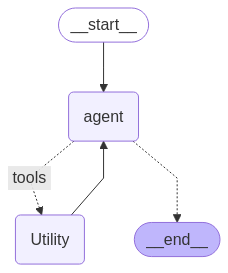

In [32]:

workflow01.add_node("agent", run_agent)
workflow01.add_node("Utility", agent_tool)


workflow01.set_entry_point("agent")


workflow01.add_conditional_edges(
    "agent",
    tools_condition ,
    {
        "tools": "Utility",
        END: END,

    },
)

workflow01.add_edge("Utility", "agent") 

graph01 = workflow01.compile(checkpointer=memory) 


from IPython.display import Image, display
try:
    display(Image(graph01.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [33]:
from langchain_core.messages import HumanMessage

while True:
    user_input = input("Your question: ")
    if user_input.lower() == "exit":
        break

    input_message = [HumanMessage(content=user_input)]
    config = {"configurable": {"session_id": "abc123", "thread_id": "abc123"}}

    for step in graph01.stream({"messages": input_message}, config=config, stream_mode="values"):
        if "messages" in step and step["messages"]:
            last_message = step["messages"][-1]
            if hasattr(last_message, "pretty_print"):
                last_message.pretty_print()
            else:
                print(last_message)

================================ Human Message =================================

could you fetch all the canidates? 
================================== Ai Message ==================================
Tool Calls:
  retrive_candidates (r84hYgXXu)
 Call ID: r84hYgXXu
  Args:
================================= Tool Message =================================
Name: retrive_candidates

Candidates retrieved: [(1067971339906383873, 'Prasad', datetime.datetime(2025, 4, 30, 5, 2, 37, 356656), 'a software engineer at meta', 'Manjesh'), (1067972559791915009, 'Smith', datetime.datetime(2025, 4, 30, 5, 9, 20, 238448), 'Kevin Smith, a software engineer at Meta', 'Kevin'), (1067972964441161729, 'prasad', datetime.datetime(2025, 4, 30, 5, 11, 1, 143297), 'a software engineer at meta', 'manjesh')]
================================== Ai Message ==================================

Here are the candidates retrieved from the database:

1. **Prasad Manjesh**
   - **ID:** 1067971339906383873
   - **Description:** 

In [ ]:
import os
import psycopg2
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

# Connect to the database using the URL stored in the environment variable
conn = psycopg2.connect(os.getenv("DATABASE_URL"))
cursor = conn.cursor()
# Bellow is just a testing sequence
# # Run the query and fetch results
# with conn.cursor() as cur:
#     cur.execute("SELECT now()")
#     res = cur.fetchall()  # Retrieve all results
#     print(res)

# # Close the connection
# conn.close()


In [ ]:
import psycopg2
import os 
import dotenv 
dotenv.load_dotenv()
# Step 1: Connect to CockroachDB
connection = psycopg2.connect(
os.getenv("DATABASE_URL"),
)

cursor = connection.cursor()

# # Step 2: Create a new table
# cursor.execute(
#     """
#     DROP TABLE IF EXISTS candidates;
#     CREATE TABLE IF NOT EXISTS candidates (
#         candidate_id SERIAL PRIMARY KEY,
#         long_description TEXT
# );


#     """
# )

cursor.execute(
    """
    DROP TABLE IF EXISTS HRCandidates;

    CREATE TABLE IF NOT EXISTS HRCandidates (
        id SERIAL PRIMARY KEY,
        description TEXT NOT NULL, 
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        first_name VARCHAR(50) NOT NULL,
        last_name VARCHAR(50) NOT NULL
);

    

    """
)

# Step 3: Insert a new row
cursor.execute(
    """
    INSERT INTO HRCandidates (description, first_name, last_name)
    VALUES (%s, %s, %s)
    """,
    ('this is a test canidate','Manjesh', 'Prasad')
)

# # Save (commit) changes
connection.commit()

# Step 4: Query the table to confirm
cursor.execute("SELECT * FROM HRCandidates")
rows = cursor.fetchall()
print(rows)

# Step 5: Close connections
cursor.close()
connection.close()


[(1067964395977768961, 'this is a test canidate', datetime.datetime(2025, 4, 30, 4, 27, 48, 887513), 'Manjesh', 'Prasad')]
